In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

In [2]:
import os
import pandas as pd

# Base directory where both unzipped folders exist
Ravdess = "/kaggle/input/ravdess/"

file_emotion = []
file_path = []

# Loop through both folders: speech and song
for folder in os.listdir(Ravdess):
    folder_path = os.path.join(Ravdess, folder)
    
    if not os.path.isdir(folder_path):
        continue

    # Loop through Actor folders
    for actor in os.listdir(folder_path):
        actor_path = os.path.join(folder_path, actor)
        
        if not os.path.isdir(actor_path):
            continue

        for file in os.listdir(actor_path):
            part = file.split('.')[0].split('-')
            emotion_id = int(part[2])
            full_path = os.path.join(actor_path, file)

            file_emotion.append(emotion_id)
            file_path.append(full_path)

# Create dataframe
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
df = pd.concat([emotion_df, path_df], axis=1)

# Replace numeric emotion codes with actual labels
df.Emotions.replace({
    1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
    5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'
}, inplace=True)

# Preview the final dataframe
df.head()


/tmp/ipykernel_35/1633560474.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.Emotions.replace({


,Emotions,Path
0,angry,/kaggle/input/ravdess/Audio_Song_Actors_01-24/...
1,fear,/kaggle/input/ravdess/Audio_Song_Actors_01-24/...
2,happy,/kaggle/input/ravdess/Audio_Song_Actors_01-24/...
3,happy,/kaggle/input/ravdess/Audio_Song_Actors_01-24/...
4,sad,/kaggle/input/ravdess/Audio_Song_Actors_01-24/...


In [3]:
df.shape

(2452, 2)

In [4]:
df.to_csv("df.csv",index=False)

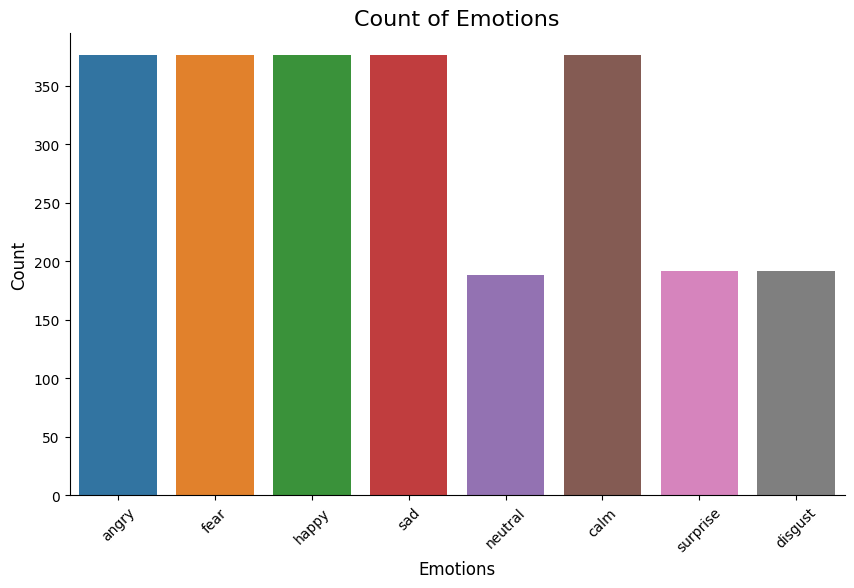

In [5]:


plt.figure(figsize=(10, 6))
plt.title('Count of Emotions', size=16)
sns.countplot(x='Emotions', data=df)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xticks(rotation=45)
plt.show()


**Data Visualization**

In [6]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

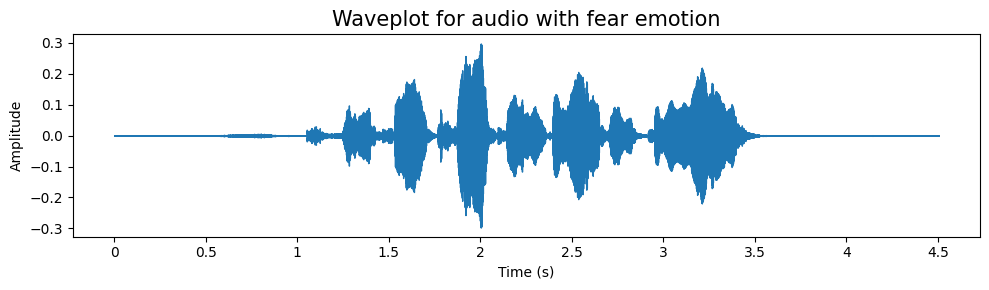

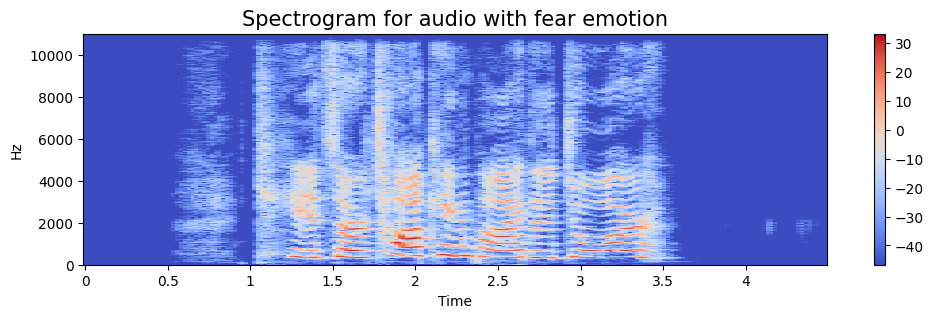

In [7]:
emotion='fear'
path = np.array(df.Path[df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

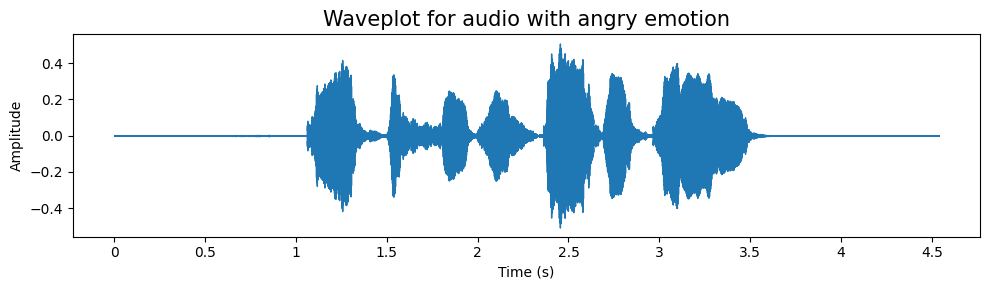

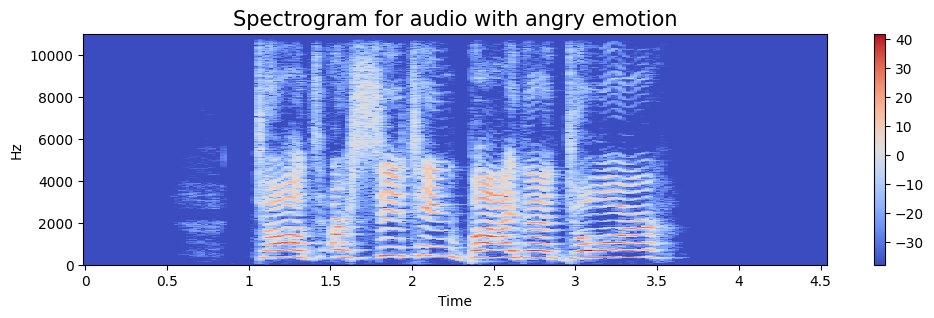

In [8]:
emotion='angry'
path = np.array(df.Path[df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

**Augmenting features**

In [9]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)


def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)


# taking any example and checking for techniques.
path = np.array(df.Path)[1]
data, sample_rate = librosa.load(path)

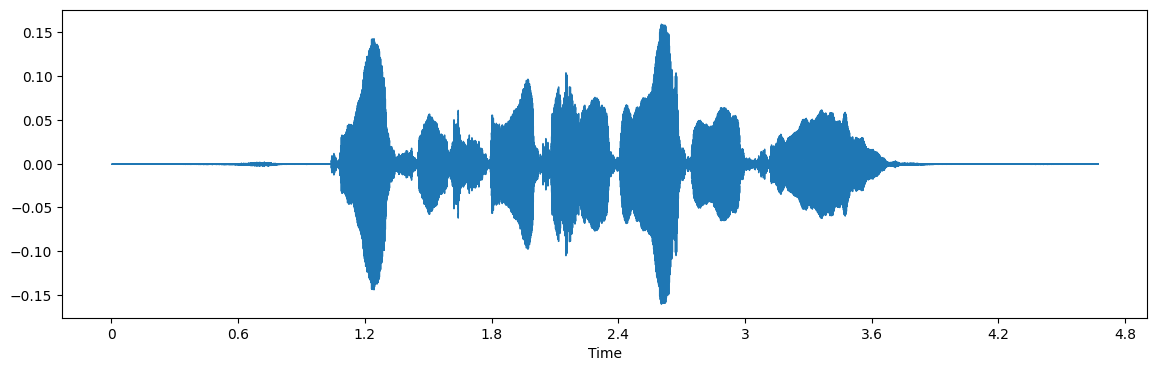

In [10]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

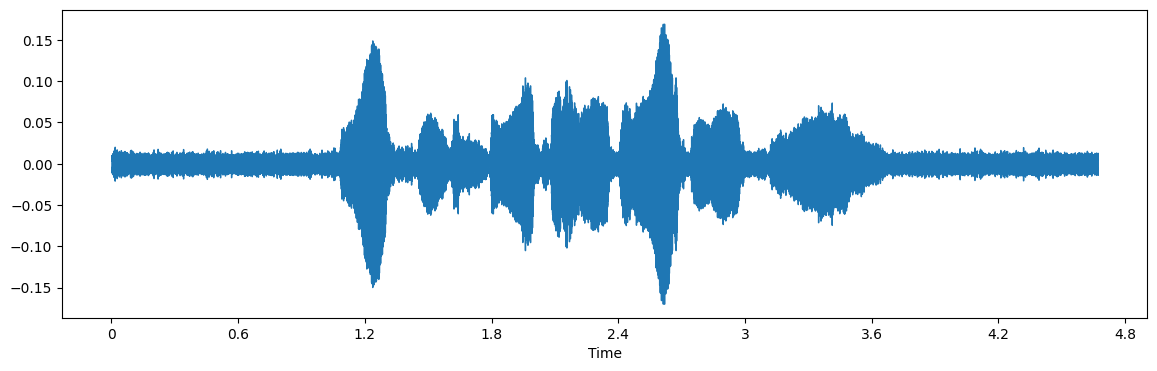

In [11]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

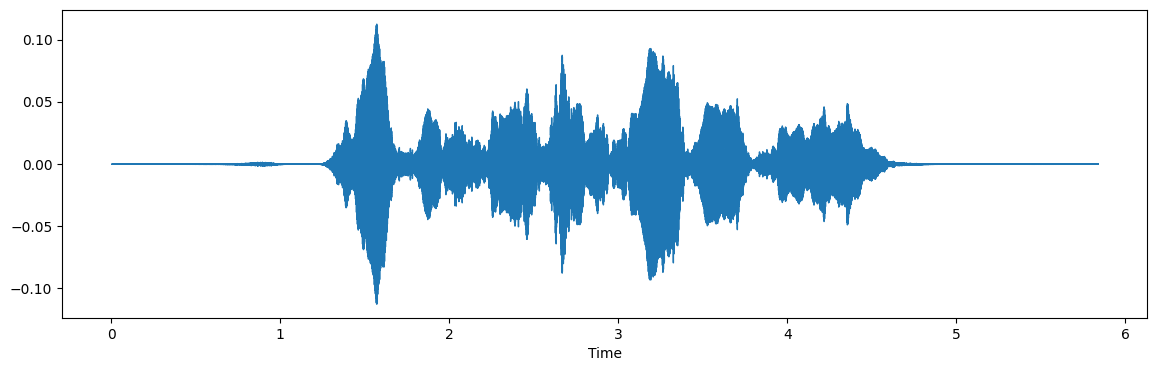

In [12]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

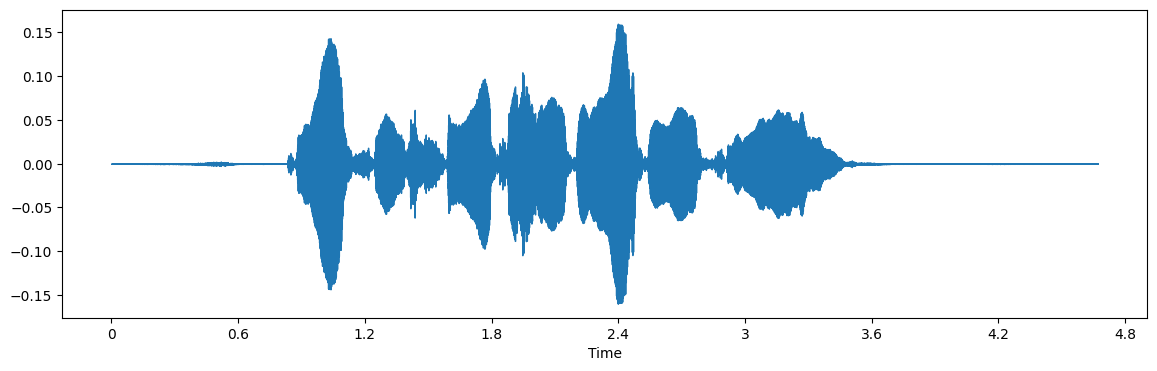

In [13]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

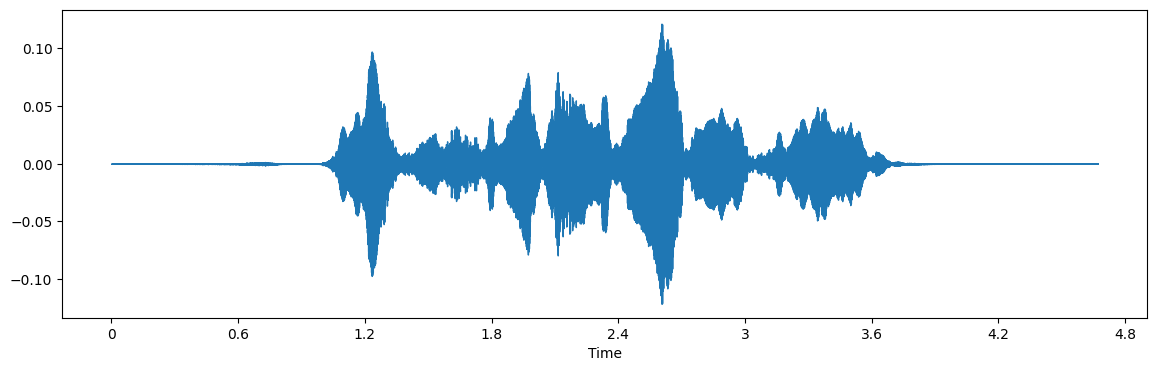

In [14]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

**Feature Extraction**

In [75]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path, augment=True):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    res = extract_features(data)
    result = np.array([res])  # wrap in list to allow vertical stacking later
    
    if augment:
        # noise augmentation
        noise_data = noise(data)
        res2 = extract_features(noise_data)
        result = np.vstack((result, res2))
        
        # stretch and pitch augmentation
        new_data = stretch(data)
        data_stretch_pitch = pitch(new_data, sample_rate)
        res3 = extract_features(data_stretch_pitch)
        result = np.vstack((result, res3))
    
    return result


In [76]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df.Emotions, random_state=42)


In [77]:
from tqdm import tqdm

X_train, Y_train = [], []
for path, emotion in tqdm(zip(train_df.Path, train_df.Emotions), total=len(train_df)):
    feature_list = get_features(path, augment=True)
    for feature in feature_list:
        X_train.append(feature)
        Y_train.append(emotion)

X_test, Y_test = [], []
for path, emotion in tqdm(zip(test_df.Path, test_df.Emotions), total=len(test_df)):
    feature_list = get_features(path, augment=False)  # no augmentation here
    for feature in feature_list:
        X_test.append(feature)
        Y_test.append(emotion)


100%|██████████| 491/491 [00:15<00:00, 30.82it/s]


In [78]:
# Convert to DataFrame
train_features = pd.DataFrame(X_train)
train_features['labels'] = Y_train
train_features.to_csv('train_features.csv', index=False)

test_features = pd.DataFrame(X_test)
test_features['labels'] = Y_test
test_features.to_csv('test_features.csv', index=False)


In [79]:
# Load train and test CSVs
train_df = pd.read_csv('train_features.csv')
test_df = pd.read_csv('test_features.csv')

# Separate features and labels
X_train = train_df.iloc[:, :-1].values
Y_train = train_df['labels'].values

X_test = test_df.iloc[:, :-1].values
Y_test = test_df['labels'].values


In [80]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
Y_train_oh = encoder.fit_transform(Y_train.reshape(-1, 1)).toarray()
Y_test_oh = encoder.transform(Y_test.reshape(-1, 1)).toarray()


In [81]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled.shape

(5883, 162)

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score,  accuracy_score
)
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [83]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [130]:
# ====================
# 1. Model definition
# ====================
class EnhancedCNNLSTM(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedCNNLSTM, self).__init__()
        
        # Multi-scale CNN with residual connections
        self.conv_block1 = self._make_multiscale_block(1, 32)
        self.conv_block2 = self._make_multiscale_block(32, 64)
        
        # Pooling layers
        self.pool1 = nn.MaxPool2d((1, 2))
        self.pool2 = nn.MaxPool2d((1, 3))
        
        # LSTM configuration (maintains your original dimensions)
        self.lstm_input_size = 64 * 9  # 576
        self.lstm_hidden = 96
        
        # Bidirectional LSTM with layer normalization
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_size,
            hidden_size=self.lstm_hidden,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=0.2
        )
        
        # Multi-head attention mechanism
        self.attention = nn.MultiheadAttention(
            embed_dim=self.lstm_hidden * 2,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )
        
        # Statistical pooling unit
        self.stat_pooling = StatisticalPooling()
        
        # Enhanced classifier with residual connection
        self.fc = nn.Sequential(
            nn.Linear(self.lstm_hidden * 4, 256),  # *4 for bidirectional + stat pooling
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(128, num_classes)
        )
        
        self._init_weights()
    
    def _make_multiscale_block(self, in_channels, out_channels):
        # Split channels as evenly as possible without dropping any
        c1 = out_channels // 3
        c2 = out_channels // 3
        c3 = out_channels - (c1 + c2)  # Remainder goes to last branch to make total exact
    
        return nn.ModuleDict({
            'conv1x1': nn.Conv2d(in_channels, c1, kernel_size=1),
            'conv3x3': nn.Conv2d(in_channels, c2, kernel_size=3, padding=1),
            'conv5x5': nn.Conv2d(in_channels, c3, kernel_size=5, padding=2),
            'bn': nn.BatchNorm2d(out_channels),
            'residual': nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()
        })


    
    def _apply_multiscale_block(self, x, block):
        """Apply multi-scale convolution with residual connection"""
        # Multi-scale convolutions
        conv1 = block['conv1x1'](x)
        conv3 = block['conv3x3'](x)
        conv5 = block['conv5x5'](x)
        
        # Concatenate multi-scale features
        out = torch.cat([conv1, conv3, conv5], dim=1)
        out = block['bn'](out)
        
        # Residual connection
        residual = block['residual'](x)
        out = F.relu(out + residual)
        
        return out
    
    def _init_weights(self):
        """Advanced weight initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight_ih' in name:
                        nn.init.kaiming_normal_(param)
                    elif 'weight_hh' in name:
                        nn.init.orthogonal_(param)
                    elif 'bias' in name:
                        nn.init.constant_(param, 0)
    
    def forward(self, x):
        # Multi-scale CNN with residual connections
        x = self._apply_multiscale_block(x, self.conv_block1)  # [B, 32, H, W]
        x = self.pool1(x)  # [B, 32, H, W/2]
        x = F.dropout(x, p=0.3, training=self.training)
        
        x = self._apply_multiscale_block(x, self.conv_block2)  # [B, 64, H, W/2]
        x = self.pool2(x)  # [B, 64, 9, 3]
        x = F.dropout(x, p=0.3, training=self.training)
        
        # Reshape for LSTM (maintaining your original approach)
        x = x.permute(0, 3, 1, 2)  # [B, 3, 64, 9]
        x = x.contiguous().view(x.size(0), x.size(1), -1)  # [B, 3, 576]
        
        # Bidirectional LSTM
        lstm_out, _ = self.lstm(x)  # [B, 3, 192]
        
        # Multi-head attention
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)  # [B, 3, 192]
        enhanced_features = lstm_out + attn_out  # Residual connection
        
        # Statistical pooling (mean + std across time dimension)
        pooled_features = self.stat_pooling(enhanced_features)  # [B, 384]
        
        # Final classification
        output = self.fc(pooled_features)
        
        return output


class StatisticalPooling(nn.Module):
    """Statistical pooling unit for better temporal feature aggregation"""
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        # x shape: [batch, time, features]
        mean = torch.mean(x, dim=1)  # [batch, features]
        std = torch.std(x, dim=1)    # [batch, features]
        return torch.cat([mean, std], dim=1)  # [batch, features*2]


# Training utilities
class AdaptiveDropout(nn.Module):
    """Adaptive dropout that changes rate during training"""
    def __init__(self, initial_p=0.5, final_p=0.1, total_epochs=100):
        super().__init__()
        self.initial_p = initial_p
        self.final_p = final_p
        self.total_epochs = total_epochs
        self.current_epoch = 0
    
    def forward(self, x):
        if self.training:
            current_p = self.initial_p - (self.initial_p - self.final_p) * (self.current_epoch / self.total_epochs)
            return F.dropout(x, p=current_p, training=True)
        return x
    
    def step_epoch(self):
        self.current_epoch += 1


# Usage example with training configuration
def create_enhanced_model(num_classes=7):  # 7 for typical emotion classes
    model = EnhancedCNNLSTM(num_classes)
    return model




In [131]:
# ====================
# 2. Data Preparation
# ====================

# Assuming x_train, y_train, x_test, y_test are loaded and one-hot labels
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x_train_tensor = torch.tensor(X_train_scaled.reshape(-1, 1, 9, 18), dtype=torch.float32)
x_test_tensor = torch.tensor(X_test_scaled.reshape(-1, 1, 9, 18), dtype=torch.float32)

y_train_tensor = torch.tensor(np.argmax(Y_train_oh, axis=1), dtype=torch.long)
y_test_tensor = torch.tensor(np.argmax(Y_test_oh, axis=1), dtype=torch.long)


le = LabelEncoder()
le.fit(y_train_tensor.numpy())
num_classes = len(le.classes_)

batch_size = 32
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
model = EnhancedCNNLSTM(num_classes).to(device)

In [132]:
# ====================
# 4. Setup for Training Loop
# ====================
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=1e-3, 
    weight_decay=0.01,
    betas=(0.9, 0.999)
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=10, 
    T_mult=2, 
    eta_min=1e-6
)

best_acc = 0.0



In [135]:
# ====================
# 4. Training Loop
# ====================
epochs=100
for epoch in range(1, epochs + 1):
    # — Training —
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for xb, yb in tqdm(train_loader, desc=f"[Train {epoch}/{epochs}]"):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        running_loss += loss.item()
        preds = out.argmax(dim=1)
        correct   += (preds == yb).sum().item()
        total     += yb.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc  = correct / total


    # — Validation —
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in tqdm(test_loader, desc=f"[Val   {epoch}/{epochs}]"):
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)

            running_loss += loss.item()
            preds = out.argmax(dim=1)
            correct   += (preds == yb).sum().item()
            total     += yb.size(0)

    val_loss = running_loss / len(test_loader)
    val_acc  = correct / total


    print(f"Epoch {epoch:02d} ▶ "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss:   {val_loss:.4f}, Acc: {val_acc:.4f}")

    scheduler.step(val_loss)


    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

[Val   1/100]: 100%|██████████| 16/16 [00:00<00:00, 342.21it/s]


Epoch 01 ▶ Train Loss: 0.2879, Acc: 0.9001 | Val Loss:   0.9960, Acc: 0.7291


[Val   2/100]: 100%|██████████| 16/16 [00:00<00:00, 357.79it/s]


Epoch 02 ▶ Train Loss: 0.2969, Acc: 0.8985 | Val Loss:   0.9351, Acc: 0.7413


[Val   3/100]: 100%|██████████| 16/16 [00:00<00:00, 349.32it/s]


Epoch 03 ▶ Train Loss: 0.2866, Acc: 0.9041 | Val Loss:   1.0542, Acc: 0.7210


[Val   4/100]: 100%|██████████| 16/16 [00:00<00:00, 340.29it/s]


Epoch 04 ▶ Train Loss: 0.2935, Acc: 0.8963 | Val Loss:   1.0063, Acc: 0.7210


[Val   5/100]: 100%|██████████| 16/16 [00:00<00:00, 346.89it/s]


Epoch 05 ▶ Train Loss: 0.3004, Acc: 0.8953 | Val Loss:   1.0607, Acc: 0.7189


[Val   6/100]: 100%|██████████| 16/16 [00:00<00:00, 340.55it/s]


Epoch 06 ▶ Train Loss: 0.2674, Acc: 0.9043 | Val Loss:   1.0078, Acc: 0.7271


[Val   7/100]: 100%|██████████| 16/16 [00:00<00:00, 340.06it/s]


Epoch 07 ▶ Train Loss: 0.2776, Acc: 0.9021 | Val Loss:   1.0877, Acc: 0.7332


[Val   8/100]: 100%|██████████| 16/16 [00:00<00:00, 332.07it/s]


Epoch 08 ▶ Train Loss: 0.2693, Acc: 0.9031 | Val Loss:   1.0663, Acc: 0.7210


[Val   9/100]: 100%|██████████| 16/16 [00:00<00:00, 333.08it/s]


Epoch 09 ▶ Train Loss: 0.2742, Acc: 0.9048 | Val Loss:   1.1032, Acc: 0.7251


[Val   10/100]: 100%|██████████| 16/16 [00:00<00:00, 353.84it/s]


Epoch 10 ▶ Train Loss: 0.2696, Acc: 0.9043 | Val Loss:   1.0714, Acc: 0.7312


[Val   11/100]: 100%|██████████| 16/16 [00:00<00:00, 356.47it/s]


Epoch 11 ▶ Train Loss: 0.2713, Acc: 0.9019 | Val Loss:   0.9985, Acc: 0.7149


[Val   12/100]: 100%|██████████| 16/16 [00:00<00:00, 355.25it/s]


Epoch 12 ▶ Train Loss: 0.2654, Acc: 0.9079 | Val Loss:   1.0416, Acc: 0.7210


[Val   13/100]: 100%|██████████| 16/16 [00:00<00:00, 308.64it/s]


Epoch 13 ▶ Train Loss: 0.2619, Acc: 0.9084 | Val Loss:   1.0556, Acc: 0.7312


[Val   14/100]: 100%|██████████| 16/16 [00:00<00:00, 355.33it/s]


Epoch 14 ▶ Train Loss: 0.2608, Acc: 0.9091 | Val Loss:   1.0849, Acc: 0.7251


[Val   15/100]: 100%|██████████| 16/16 [00:00<00:00, 361.79it/s]


Epoch 15 ▶ Train Loss: 0.2620, Acc: 0.9102 | Val Loss:   1.0813, Acc: 0.7291


[Val   16/100]: 100%|██████████| 16/16 [00:00<00:00, 356.27it/s]


Epoch 16 ▶ Train Loss: 0.2471, Acc: 0.9126 | Val Loss:   1.0921, Acc: 0.7495


[Val   17/100]: 100%|██████████| 16/16 [00:00<00:00, 340.07it/s]


Epoch 17 ▶ Train Loss: 0.2632, Acc: 0.9084 | Val Loss:   1.1645, Acc: 0.7067


[Val   18/100]: 100%|██████████| 16/16 [00:00<00:00, 342.87it/s]


Epoch 18 ▶ Train Loss: 0.2380, Acc: 0.9126 | Val Loss:   1.0995, Acc: 0.7393


[Val   19/100]: 100%|██████████| 16/16 [00:00<00:00, 341.33it/s]


Epoch 19 ▶ Train Loss: 0.2419, Acc: 0.9193 | Val Loss:   1.1560, Acc: 0.7128


[Val   20/100]: 100%|██████████| 16/16 [00:00<00:00, 342.51it/s]


Epoch 20 ▶ Train Loss: 0.2336, Acc: 0.9211 | Val Loss:   1.0621, Acc: 0.7210


[Val   21/100]: 100%|██████████| 16/16 [00:00<00:00, 327.68it/s]


Epoch 21 ▶ Train Loss: 0.2423, Acc: 0.9204 | Val Loss:   1.0226, Acc: 0.7495


[Val   22/100]: 100%|██████████| 16/16 [00:00<00:00, 337.48it/s]


Epoch 22 ▶ Train Loss: 0.2611, Acc: 0.9128 | Val Loss:   1.0287, Acc: 0.7189


[Val   23/100]: 100%|██████████| 16/16 [00:00<00:00, 331.93it/s]


Epoch 23 ▶ Train Loss: 0.2208, Acc: 0.9261 | Val Loss:   1.1333, Acc: 0.7128


[Val   24/100]: 100%|██████████| 16/16 [00:00<00:00, 330.53it/s]


Epoch 24 ▶ Train Loss: 0.2493, Acc: 0.9126 | Val Loss:   1.0679, Acc: 0.7189


[Val   25/100]: 100%|██████████| 16/16 [00:00<00:00, 332.12it/s]


Epoch 25 ▶ Train Loss: 0.2296, Acc: 0.9199 | Val Loss:   1.0670, Acc: 0.7454


[Val   26/100]: 100%|██████████| 16/16 [00:00<00:00, 348.21it/s]


Epoch 26 ▶ Train Loss: 0.2136, Acc: 0.9252 | Val Loss:   1.0668, Acc: 0.7393


[Val   27/100]: 100%|██████████| 16/16 [00:00<00:00, 353.43it/s]


Epoch 27 ▶ Train Loss: 0.2251, Acc: 0.9221 | Val Loss:   1.2455, Acc: 0.6823


[Val   28/100]: 100%|██████████| 16/16 [00:00<00:00, 310.73it/s]


Epoch 28 ▶ Train Loss: 0.2166, Acc: 0.9227 | Val Loss:   1.1084, Acc: 0.7169


[Val   29/100]: 100%|██████████| 16/16 [00:00<00:00, 363.18it/s]


Epoch 29 ▶ Train Loss: 0.2171, Acc: 0.9215 | Val Loss:   1.1522, Acc: 0.7495


[Val   30/100]: 100%|██████████| 16/16 [00:00<00:00, 331.64it/s]


Epoch 30 ▶ Train Loss: 0.2389, Acc: 0.9204 | Val Loss:   1.1493, Acc: 0.7373


[Val   31/100]: 100%|██████████| 16/16 [00:00<00:00, 356.58it/s]


Epoch 31 ▶ Train Loss: 0.2356, Acc: 0.9223 | Val Loss:   1.1058, Acc: 0.7291


[Val   32/100]: 100%|██████████| 16/16 [00:00<00:00, 357.45it/s]


Epoch 32 ▶ Train Loss: 0.2207, Acc: 0.9228 | Val Loss:   1.0937, Acc: 0.7536


[Val   33/100]: 100%|██████████| 16/16 [00:00<00:00, 356.23it/s]


Epoch 33 ▶ Train Loss: 0.2251, Acc: 0.9221 | Val Loss:   1.0336, Acc: 0.7149


[Val   34/100]: 100%|██████████| 16/16 [00:00<00:00, 353.95it/s]


Epoch 34 ▶ Train Loss: 0.2021, Acc: 0.9342 | Val Loss:   1.1574, Acc: 0.7536


[Val   35/100]: 100%|██████████| 16/16 [00:00<00:00, 334.09it/s]


Epoch 35 ▶ Train Loss: 0.2277, Acc: 0.9237 | Val Loss:   1.0607, Acc: 0.7475


[Val   36/100]: 100%|██████████| 16/16 [00:00<00:00, 344.49it/s]


Epoch 36 ▶ Train Loss: 0.2159, Acc: 0.9274 | Val Loss:   1.0689, Acc: 0.7536


[Val   37/100]: 100%|██████████| 16/16 [00:00<00:00, 331.54it/s]


Epoch 37 ▶ Train Loss: 0.2094, Acc: 0.9271 | Val Loss:   1.1504, Acc: 0.7617


[Val   38/100]: 100%|██████████| 16/16 [00:00<00:00, 334.75it/s]


Epoch 38 ▶ Train Loss: 0.2071, Acc: 0.9284 | Val Loss:   1.1288, Acc: 0.7393


[Val   39/100]: 100%|██████████| 16/16 [00:00<00:00, 330.89it/s]


Epoch 39 ▶ Train Loss: 0.1889, Acc: 0.9325 | Val Loss:   1.0772, Acc: 0.7475


[Val   40/100]: 100%|██████████| 16/16 [00:00<00:00, 344.68it/s]


Epoch 40 ▶ Train Loss: 0.2155, Acc: 0.9267 | Val Loss:   1.0006, Acc: 0.7536


[Val   41/100]: 100%|██████████| 16/16 [00:00<00:00, 344.85it/s]


Epoch 41 ▶ Train Loss: 0.2165, Acc: 0.9281 | Val Loss:   1.1814, Acc: 0.7291


[Val   42/100]: 100%|██████████| 16/16 [00:00<00:00, 352.28it/s]


Epoch 42 ▶ Train Loss: 0.2083, Acc: 0.9284 | Val Loss:   1.1472, Acc: 0.7169


[Val   43/100]: 100%|██████████| 16/16 [00:00<00:00, 355.90it/s]


Epoch 43 ▶ Train Loss: 0.1975, Acc: 0.9320 | Val Loss:   1.0438, Acc: 0.7495


[Val   44/100]: 100%|██████████| 16/16 [00:00<00:00, 348.12it/s]


Epoch 44 ▶ Train Loss: 0.1879, Acc: 0.9363 | Val Loss:   1.1384, Acc: 0.7413


[Val   45/100]: 100%|██████████| 16/16 [00:00<00:00, 351.42it/s]


Epoch 45 ▶ Train Loss: 0.2060, Acc: 0.9298 | Val Loss:   1.0614, Acc: 0.7413


[Val   46/100]: 100%|██████████| 16/16 [00:00<00:00, 360.42it/s]


Epoch 46 ▶ Train Loss: 0.1823, Acc: 0.9376 | Val Loss:   1.0295, Acc: 0.7556


[Val   47/100]: 100%|██████████| 16/16 [00:00<00:00, 355.42it/s]


Epoch 47 ▶ Train Loss: 0.2131, Acc: 0.9271 | Val Loss:   1.0579, Acc: 0.7597


[Val   48/100]: 100%|██████████| 16/16 [00:00<00:00, 345.20it/s]


Epoch 48 ▶ Train Loss: 0.1881, Acc: 0.9364 | Val Loss:   1.0759, Acc: 0.7332


[Val   49/100]: 100%|██████████| 16/16 [00:00<00:00, 354.28it/s]


Epoch 49 ▶ Train Loss: 0.2000, Acc: 0.9332 | Val Loss:   1.0980, Acc: 0.7434


[Val   50/100]: 100%|██████████| 16/16 [00:00<00:00, 351.54it/s]


Epoch 50 ▶ Train Loss: 0.1842, Acc: 0.9351 | Val Loss:   1.0835, Acc: 0.7434


[Val   51/100]: 100%|██████████| 16/16 [00:00<00:00, 349.45it/s]


Epoch 51 ▶ Train Loss: 0.1831, Acc: 0.9357 | Val Loss:   1.1434, Acc: 0.7556


[Val   52/100]: 100%|██████████| 16/16 [00:00<00:00, 336.16it/s]


Epoch 52 ▶ Train Loss: 0.1891, Acc: 0.9376 | Val Loss:   1.1021, Acc: 0.7515


[Val   53/100]: 100%|██████████| 16/16 [00:00<00:00, 324.58it/s]


Epoch 53 ▶ Train Loss: 0.1787, Acc: 0.9383 | Val Loss:   1.1573, Acc: 0.7210


[Val   54/100]: 100%|██████████| 16/16 [00:00<00:00, 342.31it/s]


Epoch 54 ▶ Train Loss: 0.1768, Acc: 0.9388 | Val Loss:   1.2226, Acc: 0.7169


[Val   55/100]: 100%|██████████| 16/16 [00:00<00:00, 333.22it/s]


Epoch 55 ▶ Train Loss: 0.1991, Acc: 0.9327 | Val Loss:   1.1198, Acc: 0.7495


[Val   56/100]: 100%|██████████| 16/16 [00:00<00:00, 331.80it/s]


Epoch 56 ▶ Train Loss: 0.1892, Acc: 0.9357 | Val Loss:   1.1074, Acc: 0.7373


[Val   57/100]: 100%|██████████| 16/16 [00:00<00:00, 348.85it/s]


Epoch 57 ▶ Train Loss: 0.1881, Acc: 0.9347 | Val Loss:   1.1997, Acc: 0.7352


[Val   58/100]: 100%|██████████| 16/16 [00:00<00:00, 335.88it/s]


Epoch 58 ▶ Train Loss: 0.1830, Acc: 0.9344 | Val Loss:   1.1176, Acc: 0.7536


[Val   59/100]: 100%|██████████| 16/16 [00:00<00:00, 316.94it/s]


Epoch 59 ▶ Train Loss: 0.1791, Acc: 0.9397 | Val Loss:   1.0308, Acc: 0.7637


[Val   60/100]: 100%|██████████| 16/16 [00:00<00:00, 346.85it/s]


Epoch 60 ▶ Train Loss: 0.1712, Acc: 0.9429 | Val Loss:   1.1594, Acc: 0.7515


[Val   61/100]: 100%|██████████| 16/16 [00:00<00:00, 332.83it/s]


Epoch 61 ▶ Train Loss: 0.1919, Acc: 0.9346 | Val Loss:   1.1234, Acc: 0.7251


[Val   62/100]: 100%|██████████| 16/16 [00:00<00:00, 346.86it/s]


Epoch 62 ▶ Train Loss: 0.1699, Acc: 0.9390 | Val Loss:   1.2398, Acc: 0.7230


[Val   63/100]: 100%|██████████| 16/16 [00:00<00:00, 354.62it/s]


Epoch 63 ▶ Train Loss: 0.1856, Acc: 0.9398 | Val Loss:   1.1418, Acc: 0.7373


[Val   64/100]: 100%|██████████| 16/16 [00:00<00:00, 352.72it/s]


Epoch 64 ▶ Train Loss: 0.1819, Acc: 0.9388 | Val Loss:   1.1303, Acc: 0.7536


[Val   65/100]: 100%|██████████| 16/16 [00:00<00:00, 341.97it/s]


Epoch 65 ▶ Train Loss: 0.1719, Acc: 0.9424 | Val Loss:   1.1262, Acc: 0.7495


[Val   66/100]: 100%|██████████| 16/16 [00:00<00:00, 345.30it/s]


Epoch 66 ▶ Train Loss: 0.1689, Acc: 0.9432 | Val Loss:   1.1311, Acc: 0.7434


[Val   67/100]: 100%|██████████| 16/16 [00:00<00:00, 363.20it/s]


Epoch 67 ▶ Train Loss: 0.1682, Acc: 0.9424 | Val Loss:   1.1368, Acc: 0.7454


[Val   68/100]: 100%|██████████| 16/16 [00:00<00:00, 353.02it/s]


Epoch 68 ▶ Train Loss: 0.1758, Acc: 0.9403 | Val Loss:   1.1090, Acc: 0.7393


[Val   69/100]: 100%|██████████| 16/16 [00:00<00:00, 352.74it/s]


Epoch 69 ▶ Train Loss: 0.1624, Acc: 0.9459 | Val Loss:   1.1219, Acc: 0.7454


[Val   70/100]: 100%|██████████| 16/16 [00:00<00:00, 345.64it/s]


Epoch 70 ▶ Train Loss: 0.1776, Acc: 0.9410 | Val Loss:   1.1257, Acc: 0.7454


[Val   71/100]: 100%|██████████| 16/16 [00:00<00:00, 346.14it/s]


Epoch 71 ▶ Train Loss: 0.1612, Acc: 0.9458 | Val Loss:   1.0539, Acc: 0.7312


[Val   72/100]: 100%|██████████| 16/16 [00:00<00:00, 353.83it/s]


Epoch 72 ▶ Train Loss: 0.1477, Acc: 0.9487 | Val Loss:   1.1430, Acc: 0.7393


[Val   73/100]: 100%|██████████| 16/16 [00:00<00:00, 292.05it/s]


Epoch 73 ▶ Train Loss: 0.1630, Acc: 0.9444 | Val Loss:   1.0905, Acc: 0.7454


[Val   74/100]: 100%|██████████| 16/16 [00:00<00:00, 340.51it/s]


Epoch 74 ▶ Train Loss: 0.1601, Acc: 0.9441 | Val Loss:   1.1106, Acc: 0.7312


[Val   75/100]: 100%|██████████| 16/16 [00:00<00:00, 355.90it/s]


Epoch 75 ▶ Train Loss: 0.1685, Acc: 0.9458 | Val Loss:   1.1178, Acc: 0.7128


[Val   76/100]: 100%|██████████| 16/16 [00:00<00:00, 345.89it/s]


Epoch 76 ▶ Train Loss: 0.1637, Acc: 0.9434 | Val Loss:   1.0893, Acc: 0.7373


[Val   77/100]: 100%|██████████| 16/16 [00:00<00:00, 343.87it/s]


Epoch 77 ▶ Train Loss: 0.1720, Acc: 0.9437 | Val Loss:   1.1538, Acc: 0.7088


[Val   78/100]: 100%|██████████| 16/16 [00:00<00:00, 349.30it/s]


Epoch 78 ▶ Train Loss: 0.1580, Acc: 0.9449 | Val Loss:   1.0667, Acc: 0.7352


[Val   79/100]: 100%|██████████| 16/16 [00:00<00:00, 354.47it/s]


Epoch 79 ▶ Train Loss: 0.1626, Acc: 0.9442 | Val Loss:   1.1306, Acc: 0.7413


[Val   80/100]: 100%|██████████| 16/16 [00:00<00:00, 364.85it/s]


Epoch 80 ▶ Train Loss: 0.1602, Acc: 0.9427 | Val Loss:   1.0919, Acc: 0.7576


[Val   81/100]: 100%|██████████| 16/16 [00:00<00:00, 359.47it/s]


Epoch 81 ▶ Train Loss: 0.1615, Acc: 0.9437 | Val Loss:   1.0206, Acc: 0.7760


[Val   82/100]: 100%|██████████| 16/16 [00:00<00:00, 350.38it/s]


Epoch 82 ▶ Train Loss: 0.1667, Acc: 0.9459 | Val Loss:   1.0177, Acc: 0.7536


[Val   83/100]: 100%|██████████| 16/16 [00:00<00:00, 346.60it/s]


Epoch 83 ▶ Train Loss: 0.1568, Acc: 0.9473 | Val Loss:   1.0690, Acc: 0.7312


[Val   84/100]: 100%|██████████| 16/16 [00:00<00:00, 344.75it/s]


Epoch 84 ▶ Train Loss: 0.1458, Acc: 0.9514 | Val Loss:   1.0928, Acc: 0.7413


[Val   85/100]: 100%|██████████| 16/16 [00:00<00:00, 298.07it/s]


Epoch 85 ▶ Train Loss: 0.1638, Acc: 0.9488 | Val Loss:   1.0808, Acc: 0.7495


[Val   86/100]: 100%|██████████| 16/16 [00:00<00:00, 332.37it/s]


Epoch 86 ▶ Train Loss: 0.1636, Acc: 0.9442 | Val Loss:   1.0371, Acc: 0.7495


[Val   87/100]: 100%|██████████| 16/16 [00:00<00:00, 340.74it/s]


Epoch 87 ▶ Train Loss: 0.1565, Acc: 0.9473 | Val Loss:   1.0626, Acc: 0.7556


[Val   88/100]: 100%|██████████| 16/16 [00:00<00:00, 338.44it/s]


Epoch 88 ▶ Train Loss: 0.1375, Acc: 0.9502 | Val Loss:   1.1146, Acc: 0.7434


[Val   89/100]: 100%|██████████| 16/16 [00:00<00:00, 337.56it/s]


Epoch 89 ▶ Train Loss: 0.1513, Acc: 0.9480 | Val Loss:   1.0572, Acc: 0.7454


[Val   90/100]: 100%|██████████| 16/16 [00:00<00:00, 337.78it/s]


Epoch 90 ▶ Train Loss: 0.1513, Acc: 0.9502 | Val Loss:   1.1219, Acc: 0.7373


[Val   91/100]: 100%|██████████| 16/16 [00:00<00:00, 344.35it/s]


Epoch 91 ▶ Train Loss: 0.1584, Acc: 0.9456 | Val Loss:   0.9821, Acc: 0.7454


[Val   92/100]: 100%|██████████| 16/16 [00:00<00:00, 345.54it/s]


Epoch 92 ▶ Train Loss: 0.1366, Acc: 0.9526 | Val Loss:   1.1058, Acc: 0.7332


[Val   93/100]: 100%|██████████| 16/16 [00:00<00:00, 341.59it/s]


Epoch 93 ▶ Train Loss: 0.1455, Acc: 0.9476 | Val Loss:   1.1618, Acc: 0.7352


[Val   94/100]: 100%|██████████| 16/16 [00:00<00:00, 348.34it/s]


Epoch 94 ▶ Train Loss: 0.1627, Acc: 0.9519 | Val Loss:   1.0338, Acc: 0.7373


[Val   95/100]: 100%|██████████| 16/16 [00:00<00:00, 365.88it/s]


Epoch 95 ▶ Train Loss: 0.1436, Acc: 0.9536 | Val Loss:   1.1719, Acc: 0.7312


[Val   96/100]: 100%|██████████| 16/16 [00:00<00:00, 354.78it/s]


Epoch 96 ▶ Train Loss: 0.1608, Acc: 0.9456 | Val Loss:   1.1321, Acc: 0.7536


[Val   97/100]: 100%|██████████| 16/16 [00:00<00:00, 354.33it/s]


Epoch 97 ▶ Train Loss: 0.1365, Acc: 0.9538 | Val Loss:   1.0513, Acc: 0.7617


[Val   98/100]: 100%|██████████| 16/16 [00:00<00:00, 353.30it/s]


Epoch 98 ▶ Train Loss: 0.1339, Acc: 0.9519 | Val Loss:   1.1629, Acc: 0.7413


[Val   99/100]: 100%|██████████| 16/16 [00:00<00:00, 354.00it/s]


Epoch 99 ▶ Train Loss: 0.1346, Acc: 0.9561 | Val Loss:   1.1300, Acc: 0.7536


[Val   100/100]: 100%|██████████| 16/16 [00:00<00:00, 355.64it/s]

Epoch 100 ▶ Train Loss: 0.1342, Acc: 0.9529 | Val Loss:   1.0760, Acc: 0.7536



Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.79      0.76        75
           1       0.83      0.96      0.89        75
           2       0.81      0.64      0.71        39
           3       0.72      0.69      0.71        75
           4       0.79      0.71      0.75        75
           5       0.78      0.74      0.76        38
           6       0.79      0.79      0.79        75
           7       0.79      0.85      0.81        39

    accuracy                           0.78       491
   macro avg       0.78      0.77      0.77       491
weighted avg       0.78      0.78      0.77       491

Confusion Matrix:
[[59  2  3  3  6  1  0  1]
 [ 0 72  0  0  0  0  3  0]
 [ 5  3 25  2  2  0  1  1]
 [ 9  0  1 52  3  1  6  3]
 [ 4  2  2  5 53  2  5  2]
 [ 0  5  0  1  1 28  1  2]
 [ 2  3  0  7  0  4 59  0]
 [ 2  0  0  2  2  0  0 33]]
Accuracy: 0.7760


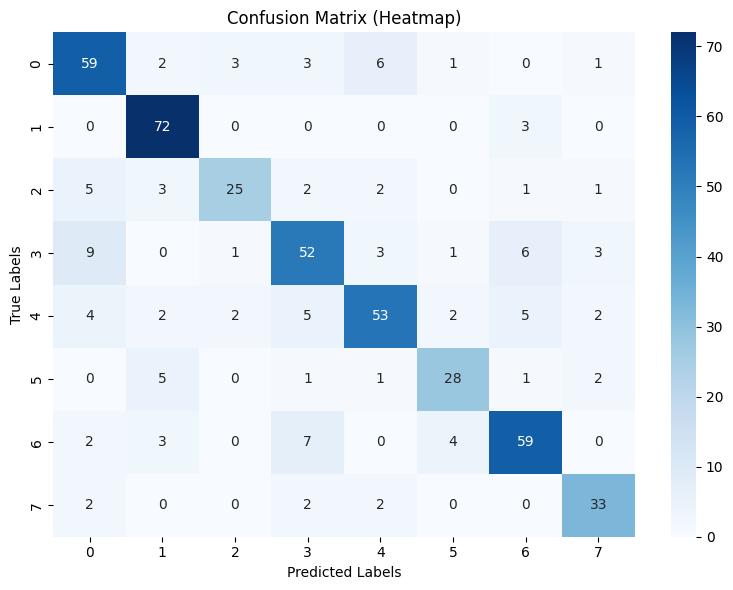

In [136]:
# ====================
# 5. Final Evaluation
# ====================
model.load_state_dict(torch.load("/kaggle/working/best_model.pth", map_location=device))
model.to(device)
model.eval()  

y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_true.extend(yb.numpy())
        y_pred.extend(preds)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[str(c) for c in le.classes_]))

print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")

# ====================
# 6. Confusion Matrix
# ====================

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(c) for c in le.classes_],
            yticklabels=[str(c) for c in le.classes_])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Heatmap)')
plt.tight_layout()
plt.show()
